**Install Dependencies**


In [1]:
#@title  <-- Run Me: (Hidden) Installing Spark
%%bash 

## Setup Spark on Colab
pip install -q pyspark
apt-get -qq install -y openjdk-8-jdk-headless

## Setup port-forwarding

# Download ngrok
wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# Unload ngrok
unzip -q ngrok-stable-linux-amd64.zip

replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [2]:
#@title  <-- Run Me: (Hidden) Environment Variable Setup
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
import pyspark 
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf, SQLContext 

# Set configuration scope to be local and use port 4050
config_scope = SparkConf().set("spark.ui.port", "4050")

# Create the connection to a Spark cluster
sc = pyspark.SparkContext(conf = config_scope)

# Create a session to programmatically build Spark RDD, DataFrame and DataSet
spark = SparkSession.builder.getOrCreate()

**Load Dataset**

In [4]:
# connect with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# unzip zip file
!unzip /content/drive/MyDrive/stat480/london.csv.zip

Archive:  /content/drive/MyDrive/stat480/london.csv.zip
replace london.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
# read in london dataset
df = spark.read.format("csv").option("header", "true")\
  .load("london.csv")

In [7]:
df = df.toDF(*["rental_id", "duration", "bike_id", "end_rental_date_time", "end_station_id", "end_station_name", "start_rental_date_time", "start_station_id", "start_station_name"])

In [8]:
# read in station dataset
df2 = spark.read.format("csv").option("header", "true")\
  .load("/content/drive/MyDrive/stat480/london_stations.csv")

**Explore dataset**

In [10]:
# use Spark-sql to show the first 10 records of london data

df.createOrReplaceTempView("london")

# Write sql query 
query = """
SELECT *
FROM london
LIMIT 10
"""

# Query data
spark.sql(query).show()

+---------+--------+-------+--------------------+--------------+--------------------+----------------------+----------------+--------------------+
|rental_id|duration|bike_id|end_rental_date_time|end_station_id|    end_station_name|start_rental_date_time|start_station_id|  start_station_name|
+---------+--------+-------+--------------------+--------------+--------------------+----------------------+----------------+--------------------+
| 61343322|    60.0|12871.0| 2016-12-28 00:01:00|         660.0|West Kensington S...|   2016-12-28 00:00:00|             633|Vereker Road Nort...|
| 61343321|   300.0| 2837.0| 2016-12-28 00:05:00|         763.0|Mile End Park Lei...|   2016-12-28 00:00:00|             531|Twig Folly Bridge...|
| 61343323|   360.0| 1269.0| 2016-12-28 00:06:00|          99.0|Old Quebec Street...|   2016-12-28 00:00:00|             116|Little Argyll Str...|
| 61343325|  1140.0| 4208.0| 2016-12-28 00:20:00|         468.0|  Cantrell Road, Bow|   2016-12-28 00:01:00|          

In [11]:
# use Spark-sql to show the first 10 records of station data

df2.createOrReplaceTempView("station")

# Write sql query 
query = """
SELECT *
FROM station
LIMIT 10
"""

# Query data
spark.sql(query).show()

+----------+--------------------+--------------------+---------+
|station_id|        station_name|           longitude| latitude|
+----------+--------------------+--------------------+---------+
|         1|River Street, Cle...|           -0.109971|  51.5292|
|         2|Phillimore Garden...|           -0.197574|  51.4996|
|         3|Christopher Stree...|          -0.0846057|  51.5213|
|         4|St. Chad's Street...|           -0.120974|  51.5301|
|         5|Sedding Street, S...|           -0.156876|  51.4931|
|         6|Broadcasting Hous...|           -0.144229|  51.5181|
|         7|Charlbert Street,...|           -0.168074|  51.5343|
|         8|Maida Vale, Maida...|-0.18348599999999998|51.529857|
|         9|New Globe Walk, B...|-0.09644080000000001|  51.5074|
|        10|Park Street, Bank...|          -0.0927542|   51.506|
+----------+--------------------+--------------------+---------+



In [12]:
# convert station data into Pandas dataframe
station = spark.sql("SELECT * FROM  station")
station_df = station.toPandas()

In [13]:
station_df

,station_id,station_name,longitude,latitude
0,1,"River Street, Clerkenwell",-0.109971,51.5292
1,2,"Phillimore Gardens, Kensington",-0.197574,51.4996
2,3,"Christopher Street, Liverpool Street",-0.0846057,51.5213
3,4,"St. Chad's Street, King's Cross",-0.120974,51.5301
4,5,"Sedding Street, Sloane Square",-0.156876,51.4931
...,...,...,...,...
797,834,"Gas Holders, Battersea Park",-0.147857,51.477965999999995
798,836,"York Way, Kings Cross",-0.125442,51.541596000000006
799,835,"Farringdon Street, Holborn",-0.10494780000000001,51.516785
800,838,"Fore Street Avenue, Guildhall",-0.09140169999999999,51.518093


In [14]:
# check column types
station_df.dtypes

station_id      object
station_name    object
longitude       object
latitude        object
dtype: object

In [15]:
# change longitude and latitude to numeric format

import pandas as pd

station_df['longitude'] = pd.to_numeric(station_df['longitude'])
station_df['latitude'] = pd.to_numeric(station_df['latitude'])

**Map Visualization of All Stations**

In [16]:
! pip install folium

In [17]:
import folium

In [18]:
map = folium.Map(location=[station_df.latitude.mean(), station_df.longitude.mean()], zoom_start=14, control_scale=True)

In [19]:
for index, location_info in station_df.iterrows():
    folium.Marker([location_info["latitude"], location_info["longitude"]], popup=location_info["station_name"], icon=folium.Icon(color='red')).add_to(map)

In [20]:
map

**Pre-pocessing** 

Construct Time Series DataFrame

In [21]:
# Change Time-unit to Hour


# Write sql query 
query = """
SELECT TIMESTAMP(date), rental_id,start_station_id  FROM 
(SELECT DATE(start_rental_date_time)|| ' ' || HOUR(start_rental_date_time) AS date, rental_id, start_station_id
FROM london)


"""

# Query data
spark.sql(query).createOrReplaceTempView("df_hours")




In [22]:
# Constrcut Time Series Data and convert it to Pandas df

query = """
SELECT date AS Date, COUNT(rental_id) AS Count  FROM df_hours
GROUP BY Date
ORDER BY Date
"""

# Query data
time_series = spark.sql(query)

time_series.createOrReplaceTempView("time_table")

time_series_df = time_series.toPandas()


Explore Time Series DF

In [24]:
time_series_df.head(10)

,Date,Count
0,2016-12-28 00:00:00,102
1,2016-12-28 01:00:00,75
2,2016-12-28 02:00:00,30
3,2016-12-28 03:00:00,28
4,2016-12-28 04:00:00,32
5,2016-12-28 05:00:00,73
6,2016-12-28 06:00:00,150
7,2016-12-28 07:00:00,365
8,2016-12-28 08:00:00,753
9,2016-12-28 09:00:00,691


In [26]:
# find the most popular station

query = """
SELECT  start_station_id, COUNT(start_station_id) AS n  
FROM df_hours
GROUP BY  start_station_id
ORDER BY n DESC
"""

# Query data
spark.sql(query).show()

+----------------+------+
|start_station_id|     n|
+----------------+------+
|              14|302906|
|             191|300157|
|             154|265974|
|             307|212675|
|             303|210948|
|             374|206698|
|             213|177004|
|             194|176231|
|             248|174248|
|             785|161430|
|             217|154760|
|             732|151743|
|             132|149329|
|             111|148380|
|             251|147822|
|             762|146196|
|             553|144237|
|             101|137797|
|             341|137731|
|             427|129703|
+----------------+------+
only showing top 20 rows



###Model Fit

In [28]:
!pip install Prophet
from fbprophet import Prophet

**Hourly Time Series Model For Whole London**

In [29]:
# train and test split
time_series_df = time_series_df.rename({'Date': 'ds', 'Count': 'y'}, axis=1)

train_set = time_series_df.iloc[0:int(len(time_series_df)*0.8)+1,:]
test_set = time_series_df.iloc[int(len(time_series_df)*0.8)+1:,:]

In [30]:
# construct time series model
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
model.fit(train_set)


In [31]:
# make prediction
future_pd = model.make_future_dataframe(
    periods=len(test_set),
    freq='h',
    include_history=True
)

forecast_pd = model.predict(future_pd)

# Set negative predictions into zero
forecast_pd['yhat'][forecast_pd['yhat']<0] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [33]:
# Calculate RMSE
import numpy as np

# train RMSE
dif1=np.subtract(np.array(train_set['y']),np.array(forecast_pd['yhat'][0:25801]))
print("Train RMSE = {0}.".format(np.sqrt(np.sum(np.square(dif1))/len(train_set['y']))))


# test RMSE
dif2=np.subtract(np.array(test_set['y']),np.array(forecast_pd['yhat'][25801:]))
print("Test RMSE = {0}.".format(np.sqrt(np.sum(np.square(dif2))/len(test_set['y']))))

Train RMSE = 698.2112963648483.
Test RMSE = 994.4359809022234.


(737394.0, 737403.0)

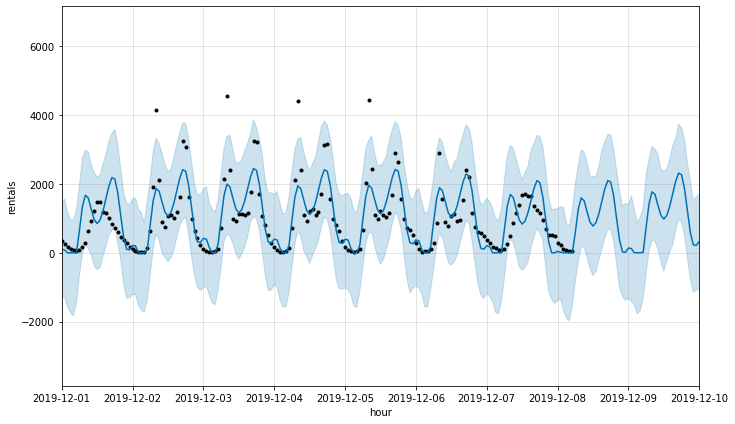

In [34]:
# Plot the result
from datetime import datetime

# construct a visualization of the forecast
predict_fig = model.plot(forecast_pd, xlabel='hour', ylabel='rentals')

# adjust the x-axis to focus on a limited date range
xlim = predict_fig.axes[0].get_xlim()
new_xlim = (datetime.strptime('2019-12-01','%Y-%m-%d'), datetime.strptime('2019-12-10','%Y-%m-%d'))
predict_fig.axes[0].set_xlim(new_xlim)

**Daily Time Series Model For Whole London**

In [35]:
# aggregate to daily unit
df3=time_series_df.groupby([time_series_df['ds'].dt.date]).mean().reset_index()
# train test split
train_set = df3.iloc[0:int(len(df3)*0.8)+1,:]
test_set = df3.iloc[int(len(df3)*0.8)+1:,:]

In [36]:
# construct the model
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
model.fit(train_set)

In [37]:
# make prediction
future_pd = model.make_future_dataframe(
    periods=len(test_set),
    freq='h',
    include_history=True
)

forecast_pd = model.predict(future_pd)
forecast_pd['yhat'][forecast_pd['yhat']<0] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
# train RMSE
dif1=np.subtract(np.array(train_set['y']),np.array(forecast_pd['yhat'][0:1076]))
print("Train RMSE = {0}.".format(np.sqrt(np.sum(np.square(dif1))/len(train_set['y']))))

# test RMSE
dif2=np.subtract(np.array(test_set['y']),np.array(forecast_pd['yhat'][1076:]))
print("Test RMSE = {0}.".format(np.sqrt(np.sum(np.square(dif2))/len(test_set['y']))))

Train RMSE = 216.8440160296664.
Test RMSE = 612.7952711796573.


(737382.0, 737408.0)

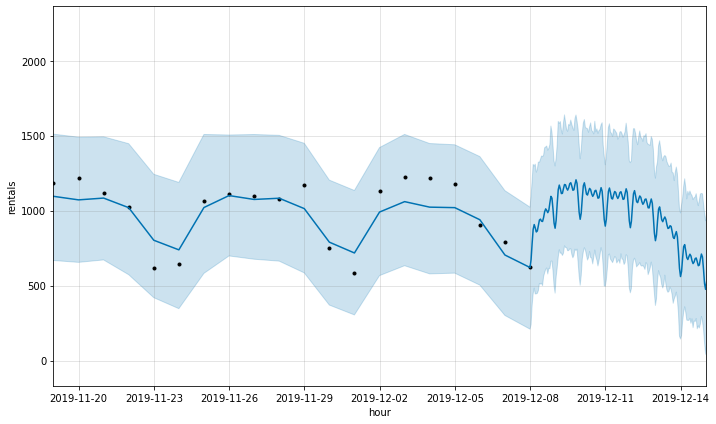

In [39]:
from datetime import datetime

# construct a visualization of the forecast
predict_fig = model.plot(forecast_pd, xlabel='hour', ylabel='rentals')

# adjust the x-axis to focus on a limited date range
xlim = predict_fig.axes[0].get_xlim()
new_xlim = (datetime.strptime('2019-11-19','%Y-%m-%d'), datetime.strptime('2019-12-15','%Y-%m-%d'))
predict_fig.axes[0].set_xlim(new_xlim)

**Hourly Time Series Model For Station ID 14**

In [40]:
# construct the time series df with only station 14 exists
time_series14 = spark.sql("""SELECT date AS Date, COUNT(rental_id) AS Count FROM df_hours 
WHERE start_station_id = 14 
GROUP BY date
ORDER BY date""")
time_series_df14 = time_series14.toPandas()

In [41]:
df4 = time_series_df14.rename({'Date': 'ds', 'Count': 'y'}, axis=1)

# train test split
train_set = df4.iloc[0:int(len(df4)*0.8)+1,:]
test_set = df4.iloc[int(len(df4)*0.8)+1:,:]

In [42]:
# constrct model
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
model.fit(train_set)

In [43]:
# make prediction
future_pd = model.make_future_dataframe(
    periods=len(test_set),
    freq='h',
    include_history=True
)

forecast_pd = model.predict(future_pd)
forecast_pd['yhat'][forecast_pd['yhat']<0] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
# train RMSE
dif1=np.subtract(np.array(train_set['y']),np.array(forecast_pd['yhat'][0:19611]))
print("Train RMSE = {0}.".format(np.sqrt(np.sum(np.square(dif1))/len(train_set['y']))))


# test RMSE
dif2=np.subtract(np.array(test_set['y']),np.array(forecast_pd['yhat'][19611:]))
print("Test RMSE = {0}.".format(np.sqrt(np.sum(np.square(dif2))/len(test_set['y']))))

Train RMSE = 19.17141729229915.
Test RMSE = 22.93629908304107.


(737364.0, 737374.0)

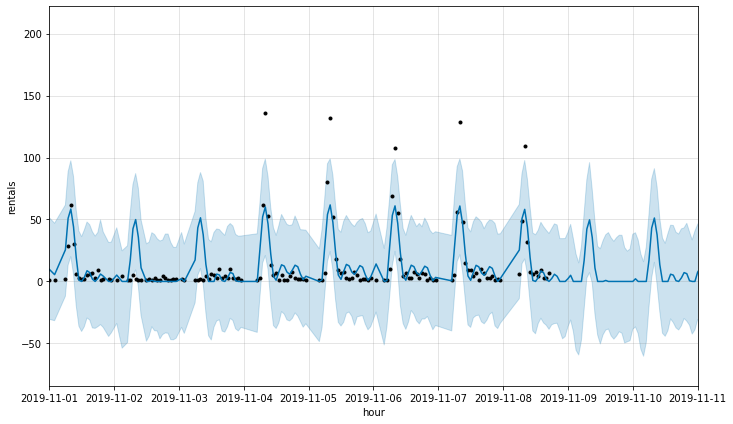

In [45]:
from datetime import datetime

# construct a visualization of the forecast
predict_fig = model.plot(forecast_pd, xlabel='hour', ylabel='rentals')

# adjust the x-axis to focus on a limited date range
xlim = predict_fig.axes[0].get_xlim()
new_xlim = (datetime.strptime('2019-11-01','%Y-%m-%d'), datetime.strptime('2019-11-11','%Y-%m-%d'))
predict_fig.axes[0].set_xlim(new_xlim)

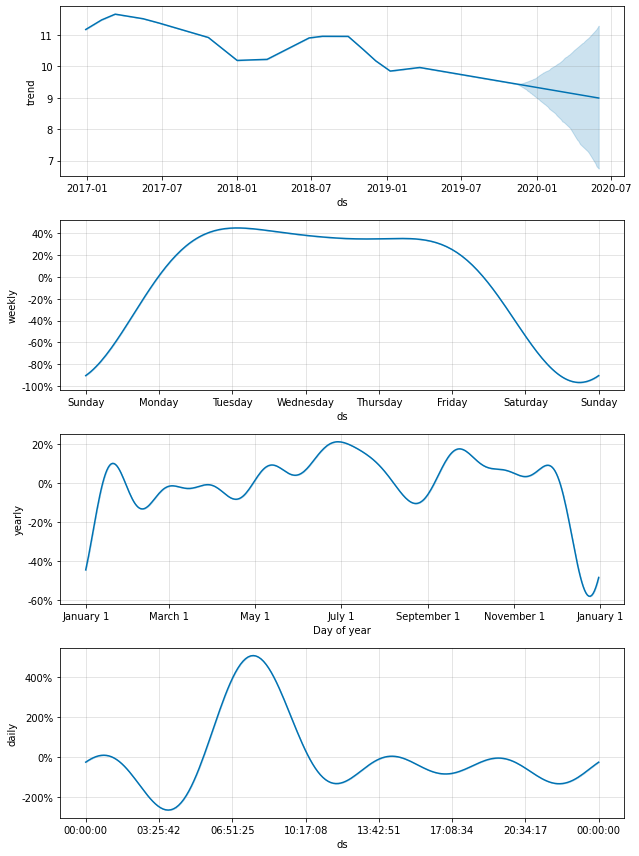

In [46]:
# make decomposition plot
trends_fig = model.plot_components(forecast_pd)
